In [2]:
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


# 서울 전체 바운더리 생성 후 버퍼 500m 생성
seoul_boundary = gpd.read_file(
    r"C:\Users\bsh96\Documents\GitHub\Smart_Coffee\seoul_boundary.shp"
)
seoul_boundary_union = seoul_boundary.unary_union
seoul_boundary_gdf = gpd.GeoDataFrame(
    geometry=[seoul_boundary_union], crs=seoul_boundary.crs
)
# 버퍼 생성
seoul_buffer = seoul_boundary_gdf.buffer(500)
# 버퍼를 GeoDataFrame으로 변환
seoul_buffer_gdf = gpd.GeoDataFrame(
    geometry=seoul_buffer, crs=seoul_boundary.crs
)


C:\Users\bsh96\AppData\Local\Temp\ipykernel_12256\3058654666.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  seoul_boundary_union = seoul_boundary.unary_union


In [7]:
# 카페 데이터 불러오기 및 GeoDataFrame 생성
seoul_cafe_df = pd.read_csv("data/cafe_open_at_2016_2024.csv", encoding="utf-8")
ggd_cafe_df = pd.read_csv("data/ggd_cafe_open_at_2016_2024.csv", encoding="utf-8")

seoul_cafe_gdf = gpd.GeoDataFrame(
    seoul_cafe_df,
    geometry=gpd.points_from_xy(seoul_cafe_df["좌표정보x(epsg5174)"], seoul_cafe_df["좌표정보y(epsg5174)"]),
    crs="EPSG:5174"
)
# ggd_cafe_gdf 생성
ggd_cafe_gdf = gpd.GeoDataFrame(
    ggd_cafe_df,
    geometry=gpd.points_from_xy(ggd_cafe_df["좌표정보x(epsg5174)"], ggd_cafe_df["좌표정보y(epsg5174)"]),
    crs="EPSG:5174"
)
# cafe_gdf의 좌표계를 grid_100m_pop_in_seoul과 맞추기
if seoul_cafe_gdf.crs != seoul_boundary_gdf.crs:
    cafe_gdf = seoul_cafe_gdf.to_crs(seoul_boundary_gdf.crs)
if ggd_cafe_gdf.crs != seoul_boundary_gdf.crs:
    ggd_cafe_gdf = ggd_cafe_gdf.to_crs(seoul_boundary_gdf.crs)

# 버퍼 밖에있는 경기도 카페까지는 생각해줄 필요 없다.
ggd_cafe_gdf = ggd_cafe_gdf[ggd_cafe_gdf.geometry.within(seoul_buffer_gdf.geometry[0])]

# CRS를 맞춘 후 concat 해야 함
if seoul_cafe_gdf.crs != ggd_cafe_gdf.crs:
    ggd_cafe_gdf = ggd_cafe_gdf.to_crs(seoul_cafe_gdf.crs)

total_cafe_gdf = gpd.GeoDataFrame(
    pd.concat([seoul_cafe_gdf, ggd_cafe_gdf], ignore_index=True),
    crs=seoul_cafe_gdf.crs
)

In [12]:
from datetime import datetime
def is_alive(row, date_to_check):
    # type: (pd.Series, datetime) -> bool
    # 해당 일자에 영업중인지 확인하는 함수
    if row["영업상태명"] == "영업/정상":
        # 인허가일자가 date_to_check보다 이전인지 확인
        if datetime.strptime(row["인허가일자"], "%Y-%m-%d") > date_to_check:
            return False
        return True

    # 폐업하였더라도 3년이상 영업한경우는 생존으로 간주
    if row["영업상태명"] == "폐업":
        start_date = datetime.strptime(row["인허가일자"], "%Y-%m-%d")
        end_date = datetime.strptime(row["폐업일자"], "%Y-%m-%d")
        # datee_to_check 가 start_date와 end_date 사이에 있는지 확인
        if start_date <= date_to_check <= end_date:
            return True

    return False

closed_seoul_cafe_gdf = seoul_cafe_gdf[seoul_cafe_gdf["영업상태명"] == "폐업"]

nearby_cafe_counts = []
for idx, row in closed_seoul_cafe_gdf.iterrows():
    center = row.geometry
    close_date = datetime.strptime(row["폐업일자"], "%Y-%m-%d")
    # 500m buffer
    buffer = center.buffer(500)
    # total_cafe_gdf에서 500m 내 카페 추출
    nearby_cafes = total_cafe_gdf[total_cafe_gdf.geometry.within(buffer)]
    # 해당 폐업일자에 살아있던 카페 수 계산
    count = nearby_cafes.apply(lambda r: is_alive(r, close_date), axis=1).sum()
    nearby_cafe_counts.append(count)

closed_seoul_cafe_gdf = closed_seoul_cafe_gdf.copy()
closed_seoul_cafe_gdf["nearby_cafe_count"] = nearby_cafe_counts

closed_seoul_cafe_gdf.head(20)

,관리번호,사업장명,좌표정보x(epsg5174),좌표정보y(epsg5174),영업상태명,인허가일자,폐업일자,geometry,nearby_cafe_count
0,3010000-101-2022-00422,매머드커피익스프레스 장충동먹자골목점,200479.632428,451095.901956,폐업,2022-11-28,2024-11-27,POINT (200479.632 451095.902),8
1,3010000-101-2016-00386,만랩커피 을지로입구역점,198217.309167,451709.930986,폐업,2016-12-05,2022-11-23,POINT (198217.309 451709.931),21
2,3010000-101-2007-00116,이디야YTN점,197504.865051,450658.592453,폐업,2007-04-18,2023-09-07,POINT (197504.865 450658.592),15
3,3010000-101-2007-00024,이디야,197786.161407,451886.574199,폐업,2007-01-18,2022-06-24,POINT (197786.161 451886.574),11
30,3100000-101-2021-00048,더 벤티,205503.722304,461314.576463,폐업,2021-02-03,2024-06-03,POINT (205503.722 461314.576),17
31,3100000-101-1997-01867,이디야 에스프레소,205430.356783,461479.613300,폐업,1997-04-07,2023-01-31,POINT (205430.357 461479.613),18
32,3100000-101-2011-00165,이디야,204772.367380,464080.593905,폐업,2011-07-01,2018-03-19,POINT (204772.367 464080.594),4
33,3100000-101-2023-00202,감성커피 노원롯데캐슬점,206799.020098,462509.638446,폐업,2023-07-03,2024-07-03,POINT (206799.02 462509.638),5
51,3160000-101-2007-00206,빽다방(구로삼성IT점),190612.779366,442662.421914,폐업,2007-06-19,2017-03-30,POINT (190612.779 442662.422),12
68,3040000-101-1981-02511,이디야(중곡역점),207333.639771,451464.267097,폐업,1981-01-22,2023-07-25,POINT (207333.64 451464.267),9



폐업한 카페의 nearby_cafe_count 기술통계:
count    595.000000
mean       7.964706
std        4.578580
min        1.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       33.000000
Name: nearby_cafe_count, dtype: float64


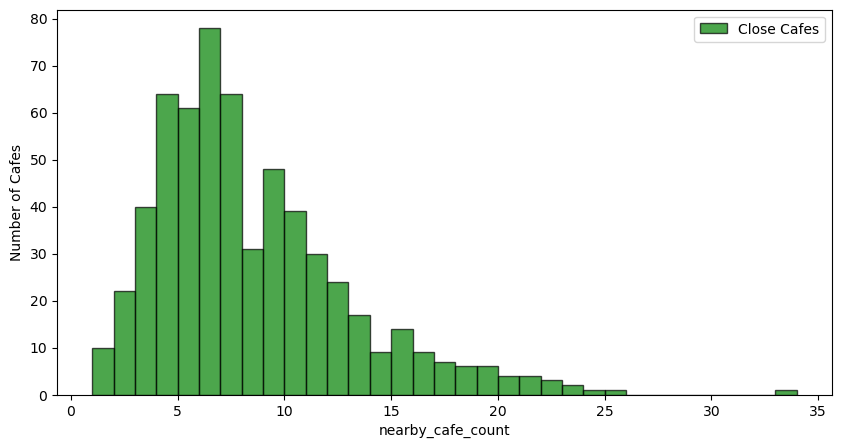

In [20]:

# 살아있는 카페와 폐업한 카페로 분리
closed_seoul_cafe_gdf_nearby_count = closed_seoul_cafe_gdf["nearby_cafe_count"]


# 기술통계 출력
print("\n폐업한 카페의 nearby_cafe_count 기술통계:")
print(closed_seoul_cafe_gdf_nearby_count.describe())
plt.figure(figsize=(10, 5))
plt.hist(closed_seoul_cafe_gdf_nearby_count, bins=range(closed_seoul_cafe_gdf_nearby_count.min(), closed_seoul_cafe_gdf_nearby_count.max() + 2), alpha=0.7, label="Close Cafes", color="green", edgecolor="black")
plt.xlabel("nearby_cafe_count")
plt.ylabel("Number of Cafes")
plt.legend()
plt.show()



In [21]:
closed_seoul_cafe_gdf.drop(columns="geometry").to_csv("cafe_with_nearby_cafe.csv", index=False, encoding="utf-8")